In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import quandl
import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

quandl.ApiConfig.api_key = "eRvW6fEn_RcPcsJVjuNp"

amzn = quandl.get('WIKI/AMZN', qopts={'columns': ['Date']})
amzn = amzn.reset_index()
amzn['Date'] = pd.to_datetime(amzn['Date'],format='%Y-%m-%d')
amzn = amzn.set_index('Date') 

In [2]:
# Get competitor data for the same date range
start = amzn.first_valid_index()
end = amzn.last_valid_index()
wmt = quandl.get('WIKI/WMT', qopts={'columns': ['Date']})
wmt = wmt.reset_index()
wmt['Date'] = pd.to_datetime(wmt['Date'],format='%Y-%m-%d')
wmt = wmt.loc[wmt['Date']>=start]
wmt = wmt.loc[wmt['Date']<=end]
wmt.rename(columns={'Volume':'WMT Volume'}, inplace=True)
# Get 5 day moving average
wmt['WMT Moving Avg.'] = wmt.loc[:,'Adj. Close'].rolling(window=5).mean()
#wmt_ma = wmt.loc[:,['Date','WMT Moving Avg.', 'WMT Volume']]
wmt_ma = wmt.loc[:,['Date','WMT Moving Avg.']]

In [3]:
# Merge competitor data
amzn = pd.merge(amzn, wmt_ma, on='Date')
amzn = amzn.set_index('Date')
df = amzn.loc[:,['Adj. Close', 'Volume', 'WMT Moving Avg.']]

# Get 5 day moving average
df['Moving Avg.'] = amzn.loc[:,'Adj. Close'].rolling(window=5).mean()
df.head()

,Adj. Close,Volume,WMT Moving Avg.,Moving Avg.
Date,,,,
1997-05-16,1.729167,1225000.0,NaN,NaN
1997-05-19,1.708333,508900.0,NaN,NaN
1997-05-20,1.635833,455600.0,NaN,NaN
1997-05-21,1.427500,1571100.0,NaN,NaN
1997-05-22,1.395833,981400.0,10.823585,1.579333


In [4]:
# Backfill missing values
df.fillna(method='bfill', inplace=True)

# Separating 10 records to predict.
df['Pred. Close'] = df['Adj. Close'].shift(-10)
x = np.array(df.drop(['Pred. Close'], 1))
x_predict = x[-10:]
x = x[:-10]
y = np.array(df['Pred. Close'])
y = y[:-10]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.002, random_state=100)

# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

conf_score = lin_reg.score(x_test, y_test)
print('Confidence Score is ', conf_score)

Confidence Score is  0.9976514215175295


In [5]:
predicted_values = lin_reg.predict(x_predict)
df['Forecast'] = np.nan

In [6]:
last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in predicted_values:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]



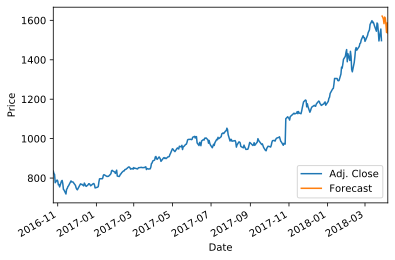

In [7]:
df['Adj. Close'].tail(365).plot()
df['Forecast'].tail(365).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

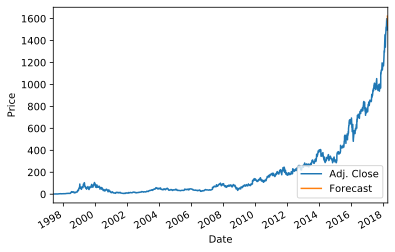

In [8]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()